In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ChromaPalette.chroma_palette import *
from matplotlib.colors import LinearSegmentedColormap

import gc
import warnings
warnings.filterwarnings('ignore')


## 1 Data Description

The objective of this competition is to use time series data generated by an online educational game to determine whether players will answer questions correctly. There are three question checkpoints (level 4, level 12, and level 22), each with a number of questions. At each checkpoint, you will have access to all previous test data for that section.

| Column Name     | Meaning                                                     |
|-----------------|-------------------------------------------------------------|
| session_id      | the ID of the session the event took place in                |
| index           | the index of the event for the session                       |
| elapsed_time    | how much time has passed (in milliseconds) between the start of the session and when the event was recorded |
| event_name      | the name of the event type                                   |
| name            | the event name (e.g., identifies whether a notebook_click is opening or closing the notebook) |
| level           | what level of the game the event occurred in (0 to 22)       |
| page            | the page number of the event (only for notebook-related events) |
| room_coor_x     | the coordinates of the click in reference to the in-game room (only for click events) |
| room_coor_y     | the coordinates of the click in reference to the in-game room (only for click events) |
| screen_coor_x   | the coordinates of the click in reference to the player's screen (only for click events) |
| screen_coor_y   | the coordinates of the click in reference to the player's screen (only for click events) |
| hover_duration  | how long (in milliseconds) the hover happened for (only for hover events) |
| text            | the text the player sees during this event                    |
| fqid            | the fully qualified ID of the event                           |
| room_fqid       | the fully qualified ID of the room the event took place in    |
| text_fqid       | the fully qualified ID of the text                            |
| fullscreen      | whether the player is in fullscreen mode                     |
| hq              | whether the game is in high-quality                          |
| music           | whether the game music is on or off                          |
| level_group     | which group of levels - and group of questions - this row belongs to (0-4, 5-12, 13-22) |



In [236]:
# Reduce Memory Usage
# reference : https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65 @ARJANGROEN

def reduce_memory_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage became: ",mem_usg," MB")
    
    return df

In [237]:
raw_train_df = pd.read_csv('train.csv')
raw_train_df = reduce_memory_usage(raw_train_df)
raw_train_df.head()

Memory usage of dataframe is 4012.60 MB
Memory usage became:  1028.2593326568604  MB


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-414.0,-159.375,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-414.0,-159.375,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-414.0,-159.375,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-414.0,-159.375,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-413.0,-159.375,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [239]:
raw_train_labels_df = pd.read_csv('train_labels.csv')
raw_train_labels_df.head()

,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090312455206810_q1,1
3,20090313091715820_q1,0
4,20090313571836404_q1,1


In [242]:
gc.collect()

51

## 2 Basic Information

#### (i) Number of rows and columns

In [74]:
print('Train:           rows', len(raw_train_df), '| columns', len(raw_train_df.columns))
print('Train_Label:  rows    ', len(raw_train_labels_df), ' | columns', len(raw_train_labels_df.columns))

Train:           rows 26296946 | columns 20
Train_Label:  rows     424116  | columns 2


#### (ii) Basic Info

In [241]:
raw_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26296946 entries, 0 to 26296945
Data columns (total 20 columns):
 #   Column          Dtype   
---  ------          -----   
 0   session_id      int64   
 1   index           int16   
 2   elapsed_time    int32   
 3   event_name      category
 4   name            category
 5   level           int8    
 6   page            float16 
 7   room_coor_x     float16 
 8   room_coor_y     float16 
 9   screen_coor_x   float16 
 10  screen_coor_y   float16 
 11  hover_duration  float32 
 12  text            category
 13  fqid            category
 14  room_fqid       category
 15  text_fqid       category
 16  fullscreen      int8    
 17  hq              int8    
 18  music           int8    
 19  level_group     category
dtypes: category(7), float16(5), float32(1), int16(1), int32(1), int64(1), int8(4)
memory usage: 1.0 GB


In [7]:
raw_train_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424116 entries, 0 to 424115
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   session_id  424116 non-null  object
 1   correct     424116 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.5+ MB


#### (iii) Check Null/NaN Values

In [283]:
def summary(df):
    print(f'data shape: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns = ['data type'])
    summary['#missing'] = df.isnull().sum().values * 100
    summary['%missing'] = df.isnull().sum().values / len(df)
    summary['#unique'] = df.nunique().values
    describe = pd.DataFrame(df.describe(include = 'all').transpose())
    summary['min'] = describe['min'].values
    summary['max'] = describe['max'].values
    return summary

In [284]:
summary_table = summary(raw_train_df)
summary_table

data shape: (26296946, 20)


,data type,#missing,%missing,#unique,min,max
session_id,int64,0,0.000000,23562,20090312431273200.0,22100221145014656.0
index,int16,0,0.000000,20348,0.0,20473.0
elapsed_time,int32,0,0.000000,5042639,0.0,1988606704.0
event_name,category,0,0.000000,11,NaN,NaN
name,category,0,0.000000,6,NaN,NaN
level,int8,0,0.000000,23,0.0,22.0
page,float16,2573240200,0.978532,7,0.0,6.0
room_coor_x,float16,207327200,0.078841,29854,-1992.0,1262.0
room_coor_y,float16,207327200,0.078841,27847,-918.0,543.5
screen_coor_x,float16,207327200,0.078841,6866,0.0,1919.0


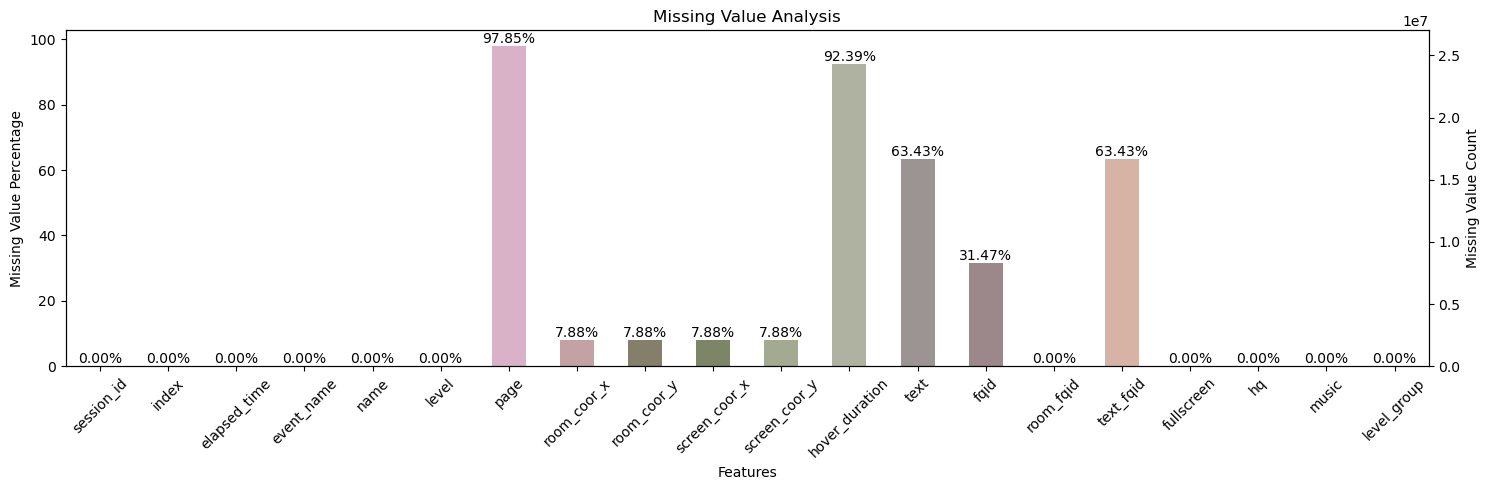

In [285]:
missing_values_train = raw_train_df.isnull().sum()
missing_percent_train = (missing_values_train / raw_train_df.shape[0]) * 100

fig, ax1 = plt.subplots(figsize = (15, 5))
missing_percent_train.plot(kind = 'bar', ax = ax1, rot = 45,
                           color = color_palette(name = "Waterlilies", N = len(raw_train_df.columns)))
ax1.set_ylabel('Missing Value Percentage')
ax1.set_xlabel('Features')
ax1.set_title('Missing Value Analysis')
for i, v in enumerate(missing_percent_train):
    ax1.text(i, v, f'{v:.2f}%', ha = 'center', va = 'bottom')

ax2 = ax1.twinx()
missing_values_train.plot(kind = 'bar', ax = ax2, alpha = 0, rot = 45)
ax2.set_ylabel('Missing Value Count')
plt.tight_layout()
plt.show()


## 3 Data Visualization

### 3.1 Features

#### (i) Session id & Index & Elapsed Time
- `session_id`: the ID of the session the event took place in
  - https://www.kaggle.com/code/pdnartreb/session-id-reverse-engineering/notebook
  - 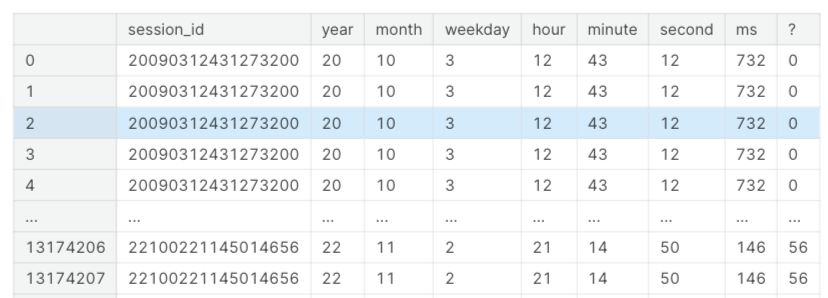  
- `index`: the index of the event in the session
  - You can assume that the `index` gives the correct order of events in cases where the elapsed_time is inconsistent
  -  `index == 0` should indicate the start of a session and there should not be duplicate events for a session.
- `elapsed_time`: how much time has passed (in milliseconds) between the start of the session and when the event was recorded

In [243]:
# session_id
raw_train_df['session_id'].nunique()

23562

#### (ii) Event

##### a. Event Types
- `event_name`: Name of the event type.
  - https://www.kaggle.com/code/shashwatraman/meaning-of-each-event-name-and-eda/notebook

Text(0.5, 1.0, 'Event Type Counts')

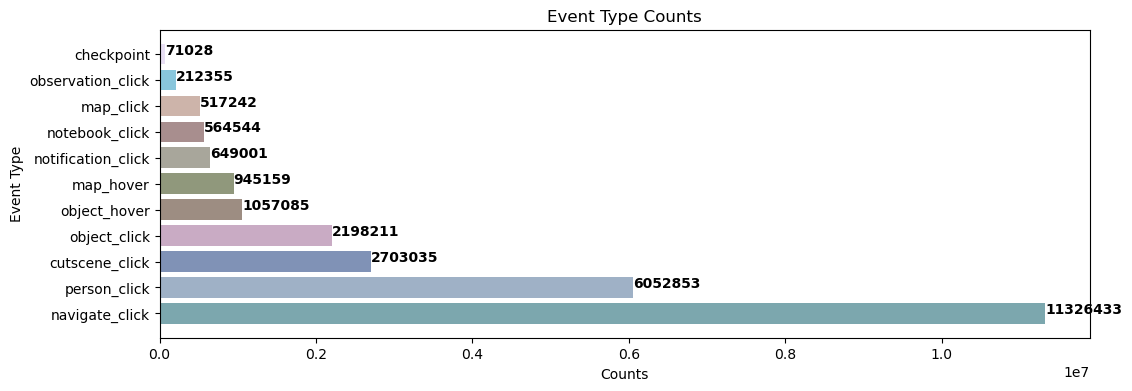

In [13]:
event_name_counts = raw_train_df['event_name'].value_counts()
color_list = color_palette(name = "Waterlilies", N = 11)
plt.figure(figsize = (12, 4))
plt.barh(event_name_counts.index, event_name_counts.values, color = color_list)
plt.xlabel('Counts')
plt.ylabel('Event Type')
for i, v in enumerate(event_name_counts.values):
    plt.text(v, i, str(v), fontweight = 'bold')
plt.title('Event Type Counts')

##### b. Event Name
- `name`: event name

Text(0.5, 1.0, 'Event Name Counts')

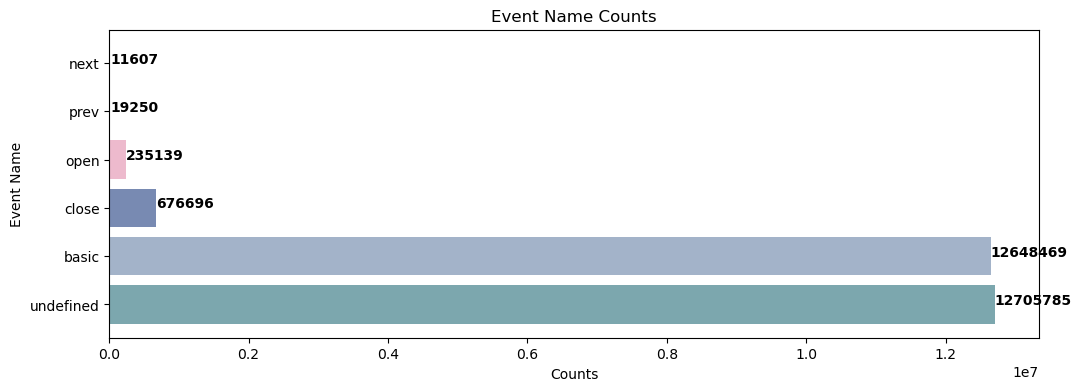

In [12]:
name_counts = raw_train_df['name'].value_counts()
color_list = color_palette(name = "Waterlilies", N = raw_train_df['name'].nunique())
plt.figure(figsize = (12, 4))
plt.barh(name_counts.index, name_counts.values, color = color_list)
plt.xlabel('Counts')
plt.ylabel('Event Name')
for i, v in enumerate(name_counts.values):
    plt.text(v, i, str(v), fontweight = 'bold')
plt.title('Event Name Counts')

In [102]:
# Event Type + Event Name
event_group_counts = raw_train_df.groupby(['event_name', 'name']).size().reset_index(name = 'counts')
event_group_counts_pivot = event_group_counts.pivot(index = 'event_name', columns = 'name', values = 'counts').fillna(0).astype(int)
event_group_counts_pivot['total'] = event_group_counts_pivot.sum(axis = 1)
event_group_counts_pivot.loc['total'] = event_group_counts_pivot.sum(axis = 0)
event_group_counts_pivot

name,basic,close,next,open,prev,undefined,total
event_name,,,,,,,
checkpoint,71028,0,0,0,0,0,71028
cutscene_click,2703035,0,0,0,0,0,2703035
map_click,46087,28623,0,0,0,442532,517242
map_hover,945159,0,0,0,0,0,945159
navigate_click,0,0,0,0,0,11326433,11326433
notebook_click,63416,235132,11607,235139,19250,0,564544
notification_click,649001,0,0,0,0,0,649001
object_click,1785270,412941,0,0,0,0,2198211
object_hover,120265,0,0,0,0,936820,1057085


#### (iiI) Level
- `level`: what level of the game the event occurred in (0 to 22)
- `level_group`: which group of levels - and group of questions - this row belongs to (0-4, 5-12, 13-22)

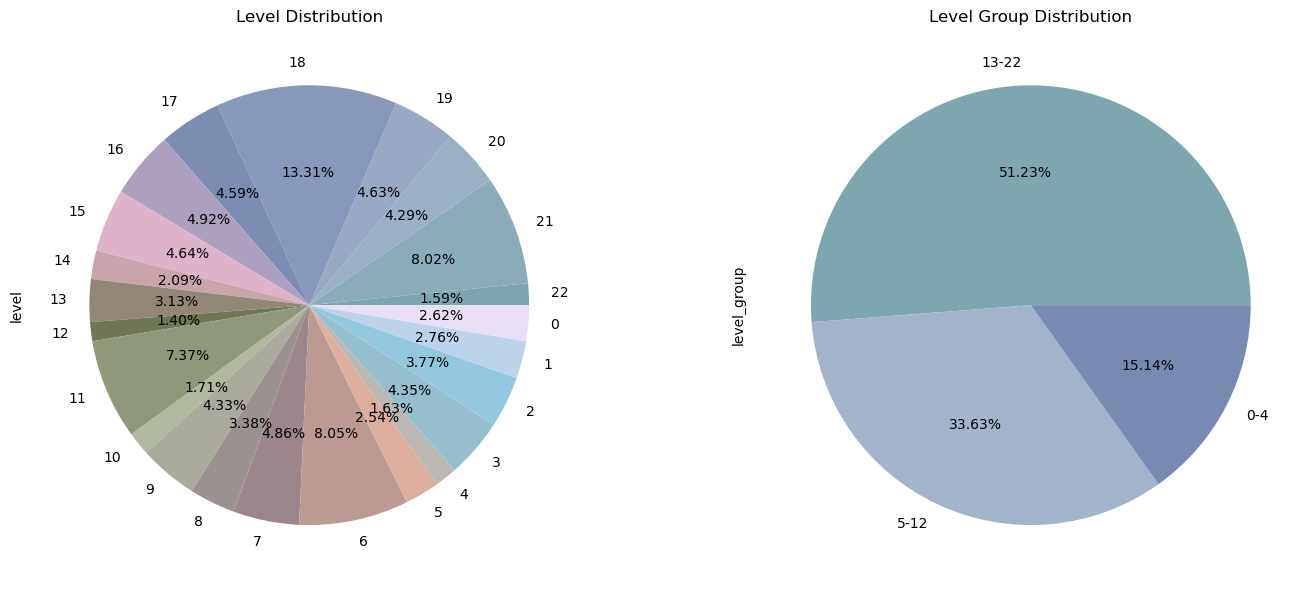

In [116]:
fig, ax = plt.subplots(1, 2, figsize = (15, 6))

# Level
level_counts = raw_train_df['level'].value_counts().sort_index(ascending = False)
level_counts.plot(kind = 'pie', autopct = '%.2f%%', colors = color_palette(name = "Waterlilies", N = raw_train_df['level'].nunique()), ax = ax[0])
ax[0].set_title('Level Distribution')

# Level Group
level_group_counts = raw_train_df['level_group'].value_counts()
level_group_counts.plot(kind = 'pie', autopct = '%.2f%%', colors = color_palette(name = "Waterlilies", N = raw_train_df['level_group'].nunique()), ax = ax[1])
ax[1].set_title('Level Group Distribution')

plt.tight_layout()
plt.show()


In [45]:
# Event Type + Level
event_level_counts = raw_train_df.groupby(['event_name', 'level']).size().reset_index(name = 'counts')
event_level_counts_pivot = event_level_counts.pivot(index = 'event_name', columns = 'level', values = 'counts').fillna(0).div(1000)
event_level_counts_pivot 

level,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
event_name,,,,,,,,,,,,,,,,,,,,,
checkpoint,0.000,0.000,0.000,0.000,23.713,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,23.633
cutscene_click,52.962,427.180,259.499,47.450,0.493,109.359,181.911,0.000,0.000,0.000,...,474.354,0.000,0.000,749.730,185.823,212.885,0.000,0.000,0.000,0.280
map_click,0.000,0.000,0.000,27.041,27.027,40.040,5.267,26.327,25.972,27.814,...,31.686,2.531,11.657,2.192,12.643,49.369,27.943,36.371,55.202,28.266
map_hover,0.000,0.000,0.000,23.029,22.101,53.617,8.613,34.253,13.803,41.468,...,51.225,6.158,29.124,4.508,28.071,86.969,50.340,112.298,155.074,53.092
navigate_click,274.973,193.781,297.467,705.194,336.391,437.526,895.775,377.343,225.777,352.477,...,248.800,405.628,830.550,514.034,737.082,1436.941,591.752,445.797,841.954,273.567
notebook_click,0.000,20.199,19.766,24.244,17.524,4.478,54.804,21.660,15.084,13.531,...,3.312,17.717,42.050,11.098,22.692,66.619,39.306,24.284,56.692,16.898
notification_click,57.564,15.745,60.488,49.446,0.000,0.000,0.000,23.805,47.512,47.486,...,0.087,0.045,42.598,1.693,2.873,24.700,23.757,24.080,119.167,3.957
object_click,51.424,47.030,87.523,178.163,0.722,4.201,4.501,326.366,89.561,202.793,...,2.344,3.531,70.046,4.094,10.535,114.161,73.237,210.741,214.891,8.911
object_hover,10.823,9.447,34.681,52.107,0.069,1.840,1.607,118.901,72.951,124.788,...,1.036,1.322,35.078,2.336,5.164,68.316,7.484,118.088,180.125,6.745


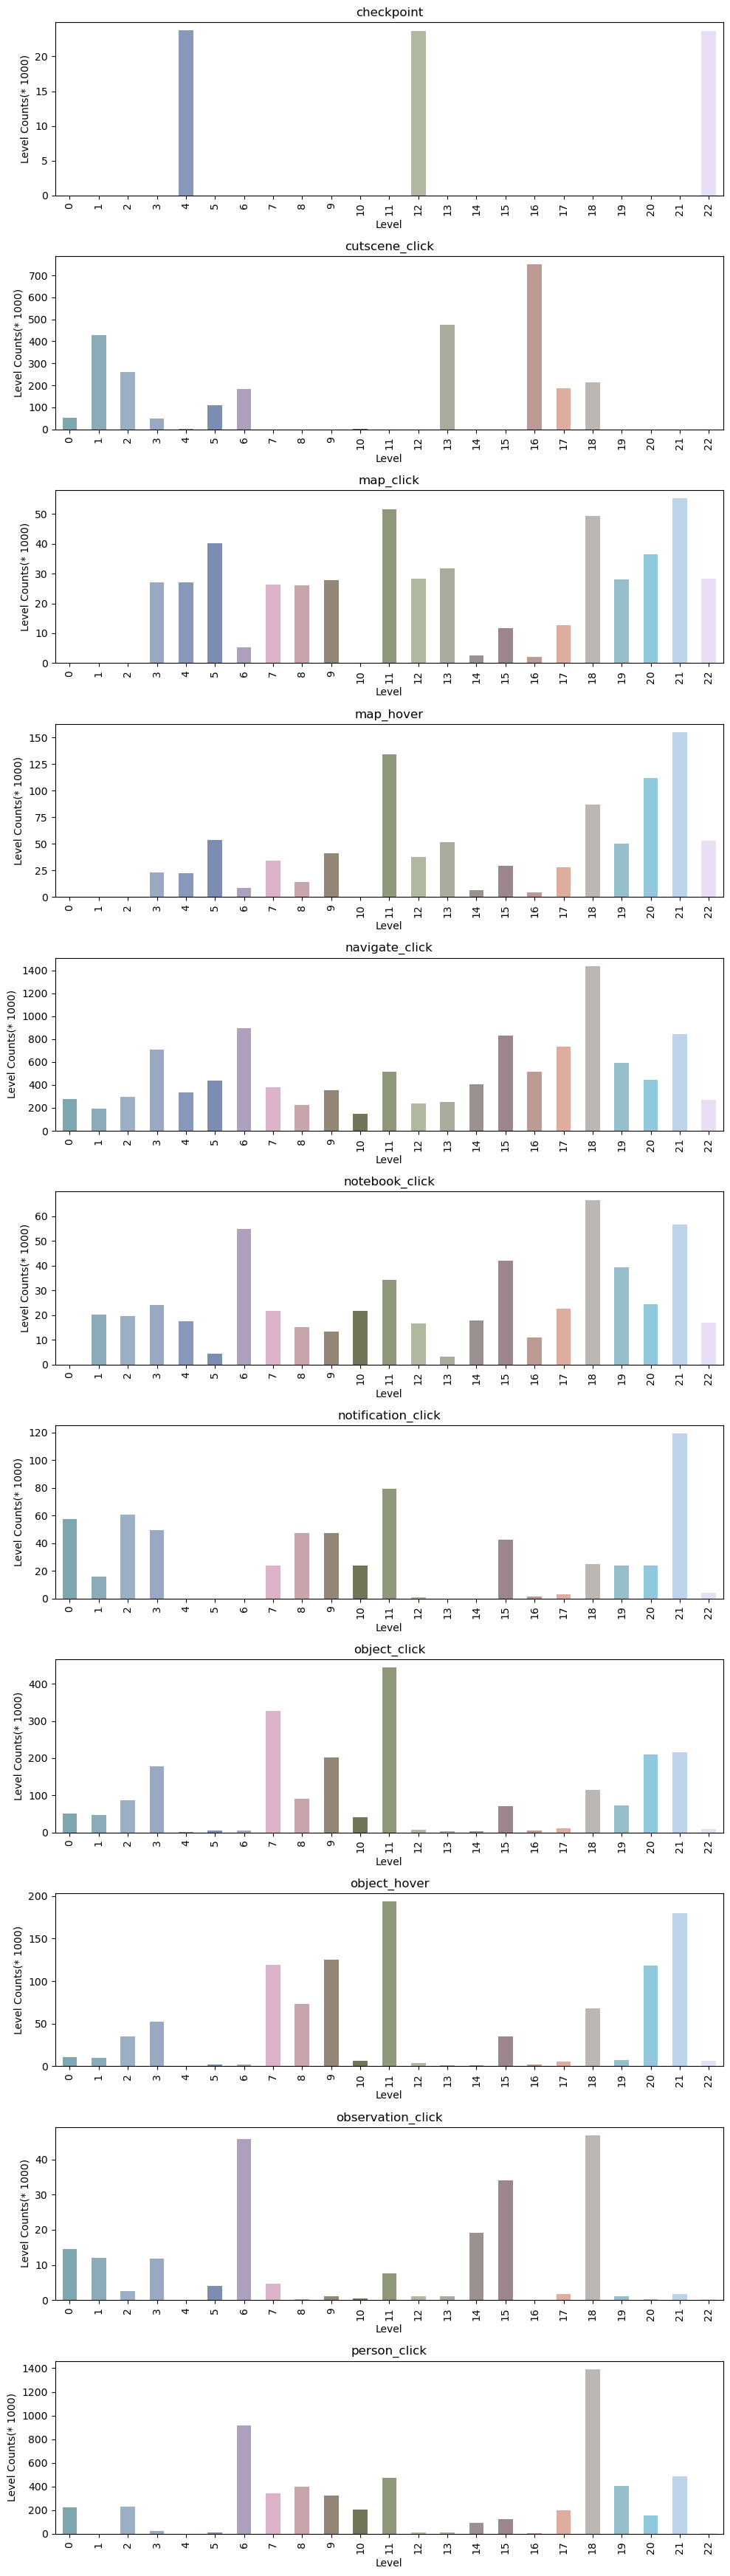

In [47]:
fig, axes = plt.subplots(11, 1, figsize = (10, 35))

for i, (event_name, data) in enumerate(event_level_counts_pivot.iterrows()):
    ax = axes[i]
    color_list = color_palette(name = "Waterlilies", N = data.shape[0])
    data.plot(kind = 'bar', ax = ax, color = color_list)
    ax.set_xlabel('Level')
    ax.set_ylabel('Level Counts(* 1000)')
    ax.set_title(event_name)
plt.tight_layout()
plt.show()

#### (iv) Page
- `page`: the page number of the event (only for notebook-related events)

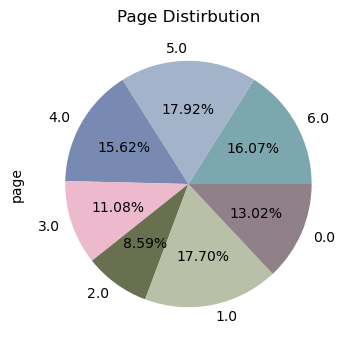

In [62]:
page_counts = raw_train_df['page'].value_counts().sort_index(ascending = False)
page_counts.plot(kind = 'pie', figsize = (4, 4), autopct = '%.2f%%', colors = color_palette(name = "Waterlilies", N = raw_train_df['page'].nunique()))
plt.title('Page Distirbution')
plt.show()

#### (v) Hover Duration
- `hover_duration`: how long (in milliseconds) the hover happened for (only for hover events)

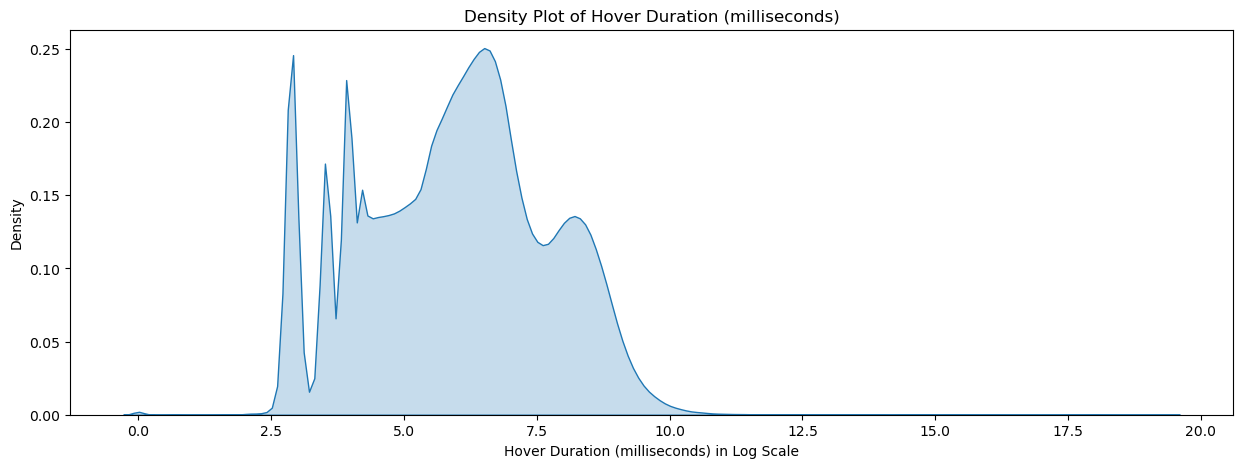

In [124]:
plt.figure(figsize = (15, 5))
sns.kdeplot(data = raw_train_df, x = np.log(raw_train_df['hover_duration'] + 1), shade = True)
plt.xlabel('Hover Duration (milliseconds) in Log Scale')
plt.ylabel('Density')
plt.title('Density Plot of Hover Duration (milliseconds)')
plt.show()

### 3.2 Target
- 0: incorrect answer to the question
- 1: correct answer to the question

In [286]:
raw_train_labels_df['session'] = raw_train_labels_df['session_id'].apply(lambda x : int(x.split('_')[0]))
raw_train_labels_df['question_id'] = raw_train_labels_df['session_id'].apply(lambda x : int(x.split('_q')[1]))
raw_train_labels_df.head()

,session_id,correct,session,question_id
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


Text(0.5, 1.0, 'Correct Counts')

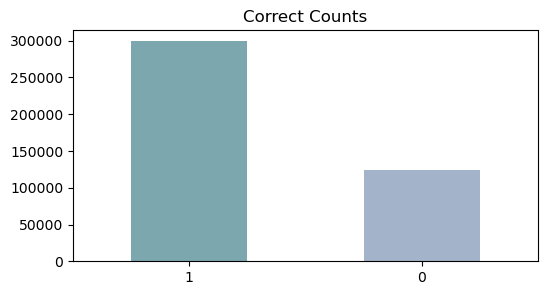

In [287]:
# correct
correct_counts = raw_train_labels_df['correct'].value_counts()
correct_counts.plot(kind = 'bar', figsize = (6, 3), rot = 0, 
                    color = color_palette(name = "Waterlilies", N = raw_train_labels_df['correct'].nunique()))
plt.title('Correct Counts')

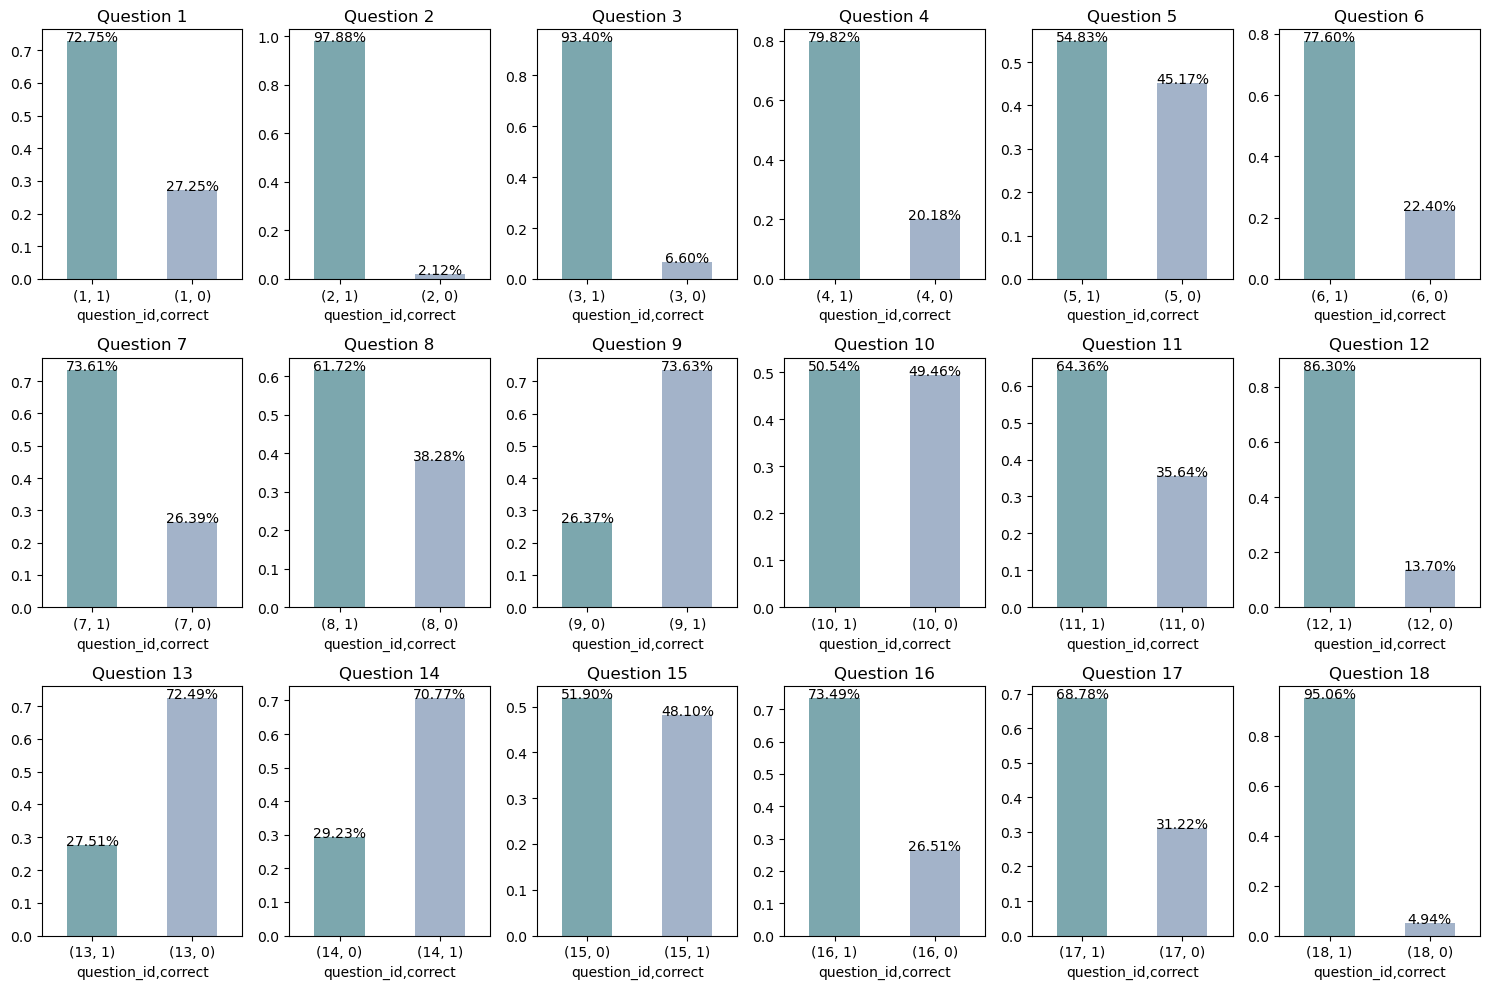

In [288]:
# correct rate for each question
correct_counts_for_each_question = raw_train_labels_df.groupby('question_id')['correct'].value_counts(normalize = True).to_frame().rename(columns = {'correct': 'correct_pct'}).sort_values(by = 'question_id')
fig, axes = plt.subplots(3, 6, figsize = (15, 10))
for i, (question_id, data) in enumerate(correct_counts_for_each_question.groupby('question_id')):
    ax = axes[i // 6, i % 6]
    data['correct_pct'].plot(kind = 'bar', ax = ax, rot = 0, 
                         color = color_palette(name = "Waterlilies", N = data['correct_pct'].nunique()))
    ax.set_title(f'Question {question_id}')
    for index, value in enumerate(data['correct_pct']):
        ax.text(index, value, f'{value:.2%}', ha = 'center')
plt.tight_layout()

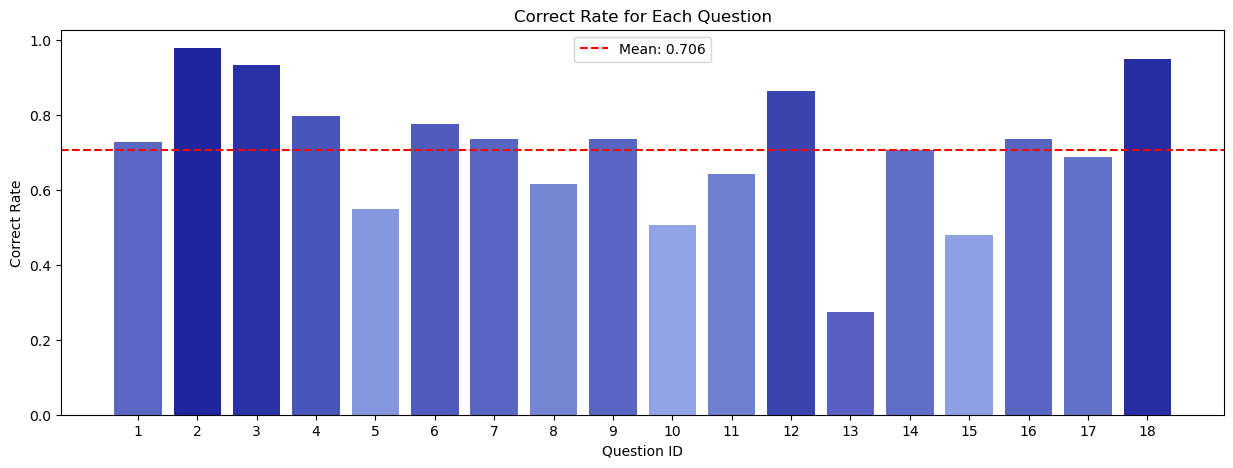

In [274]:
plt.figure(figsize = (15, 5))
colors = ["#190C9B", "#91A5E6", "#19219B"]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
plt.bar(x = np.arange(1, 19, 1),
        height = correct_counts_for_each_question.loc[(slice(None), 1), 'correct_pct'],
        color = cmap(correct_counts_for_each_question.loc[(slice(None), 1), 'correct_pct']))
plt.xlabel('Question ID')
plt.ylabel('Correct Rate')
plt.xticks(np.arange(1, 19, 1))
plt.axhline(y = correct_counts_for_each_question.loc[(slice(None), 1), 'correct_pct'].mean(), color = 'r', linestyle = '--')
plt.legend([f'Mean: {correct_counts_for_each_question.loc[(slice(None), 1), "correct_pct"].mean():.3f}'])
plt.title('Correct Rate for Each Question')
plt.show()


#### (vi) Game Room Click
- `room_fqid `: the fully qualified ID of the room the event took place in
- `room_coor_x`: the coordinates of the click in reference to the in-game room (only for click events)
- `room_coor_y`: the coordinates of the click in reference to the in-game room (only for click events)
---
- The game has 19 rooms.The plots with dots are where the 11k train users click inside these rooms. For each room, we display scatter plots where users navigate_click and where users person_click. We then use the column fqid to add names to areas of interest in the scatter plots.
  - https://www.kaggle.com/code/cdeotte/game-room-click-eda/notebook

In [388]:
ROOMS = raw_train_df.room_fqid.unique()
print('Number of rooms:', len(ROOMS))
raw_train_df.room_fqid.value_counts().index

Number of rooms: 19


CategoricalIndex(['tunic.historicalsociety.entry', 'tunic.wildlife.center',
                  'tunic.historicalsociety.cage', 'tunic.library.frontdesk',
                  'tunic.historicalsociety.frontdesk',
                  'tunic.historicalsociety.stacks',
                  'tunic.historicalsociety.closet_dirty',
                  'tunic.humanecology.frontdesk',
                  'tunic.historicalsociety.basement',
                  'tunic.kohlcenter.halloffame', 'tunic.library.microfiche',
                  'tunic.drycleaner.frontdesk',
                  'tunic.historicalsociety.collection',
                  'tunic.historicalsociety.closet', 'tunic.flaghouse.entry',
                  'tunic.historicalsociety.collection_flag',
                  'tunic.capitol_1.hall', 'tunic.capitol_0.hall',
                  'tunic.capitol_2.hall'],
                 categories=['tunic.capitol_0.hall', 'tunic.capitol_1.hall', 'tunic.capitol_2.hall', 'tunic.drycleaner.frontdesk', 'tunic.flaghouse.en

In [383]:
raw_train_df[['room_coor_x', 'room_coor_y', 'room_fqid']]

,room_coor_x,room_coor_y,room_fqid
0,-414.00,-159.3750,tunic.historicalsociety.closet
1,-414.00,-159.3750,tunic.historicalsociety.closet
2,-414.00,-159.3750,tunic.historicalsociety.closet
3,-414.00,-159.3750,tunic.historicalsociety.closet
4,-413.00,-159.3750,tunic.historicalsociety.closet
...,...,...,...
26296941,344.00,36.6875,tunic.capitol_2.hall
26296942,332.75,141.5000,tunic.capitol_2.hall
26296943,370.00,140.6250,tunic.capitol_2.hall
26296944,252.25,123.8125,tunic.capitol_2.hall


In [387]:
raw_train_df.room_fqid.value_counts().index

CategoricalIndex(['tunic.historicalsociety.entry', 'tunic.wildlife.center',
                  'tunic.historicalsociety.cage', 'tunic.library.frontdesk',
                  'tunic.historicalsociety.frontdesk',
                  'tunic.historicalsociety.stacks',
                  'tunic.historicalsociety.closet_dirty',
                  'tunic.humanecology.frontdesk',
                  'tunic.historicalsociety.basement',
                  'tunic.kohlcenter.halloffame', 'tunic.library.microfiche',
                  'tunic.drycleaner.frontdesk',
                  'tunic.historicalsociety.collection',
                  'tunic.historicalsociety.closet', 'tunic.flaghouse.entry',
                  'tunic.historicalsociety.collection_flag',
                  'tunic.capitol_1.hall', 'tunic.capitol_0.hall',
                  'tunic.capitol_2.hall'],
                 categories=['tunic.capitol_0.hall', 'tunic.capitol_1.hall', 'tunic.capitol_2.hall', 'tunic.drycleaner.frontdesk', 'tunic.flaghouse.en

## 4 Model

### 4.1 Baseline LGBM Classifier : 0.676
- https://www.kaggle.com/code/kimtaehun/lightgbm-baseline-with-aggregated-log-data

In [331]:
from lightgbm import LGBMClassifier

#### (i) Feature Engineering

##### a. Create Dummies
- `event_name`

In [351]:
train_df = raw_train_df.copy()
event_dummies = pd.get_dummies(train_df['event_name'])
train_df = pd.concat([train_df, event_dummies], axis = 1)

# 在测试集中可能有问题，参考 https://stackoverflow.com/questions/28465633/easy-way-to-apply-transformation-from-pandas-get-dummies-to-new-data

##### b. Feature_Engineer
- group by ['session_id', 'level_group']
- 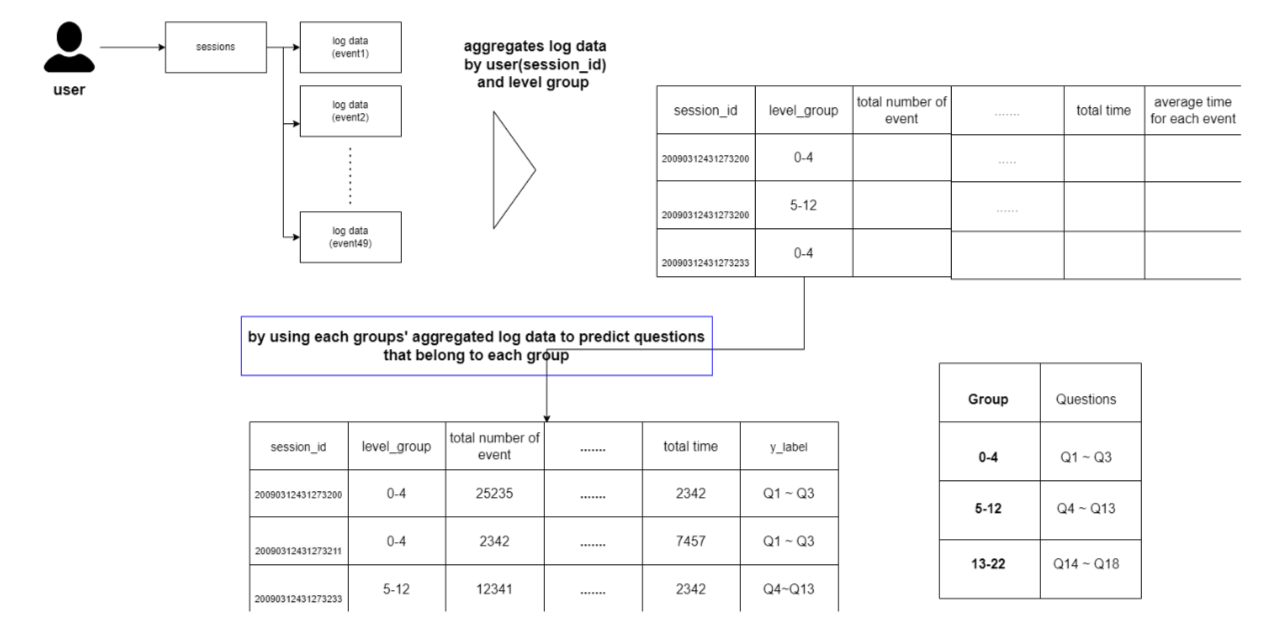

In [370]:
count_var = ['event_name', 'fqid','room_fqid', 'text']
mean_var = ['elapsed_time','level']
event_var = ['navigate_click', 'person_click', 'cutscene_click', 'object_click', 'map_hover', 'notification_click',
            'map_click', 'observation_click', 'checkpoint', 'elapsed_time']

In [358]:
# reference: https://www.kaggle.com/code/cdeotte/random-forest-baseline-0-664/notebook
# 对训练数据进行分组操作，计算各种统计特征，并将它们合并到一个新的数据框中
def feature_engineer(train):
    dfs = []
    for c in count_var:
        tmp = train.groupby(['session_id', 'level_group'])[c].nunique().rename(f'{c}_nunique')
        dfs.append(tmp)
    for c in mean_var:
        tmp = train.groupby(['session_id', 'level_group'])[c].mean()
        dfs.append(tmp)
    for c in event_var:
        tmp = train.groupby(['session_id', 'level_group'])[c].sum().rename(f'{c}_sum')
        dfs.append(tmp)
    df = pd.concat(dfs, axis=1).fillna(-1).reset_index().set_index('session_id')
    return df

In [359]:
df_tr = feature_engineer(train_df)
gc.collect()

546

In [360]:
df_tr

,level_group,event_name_nunique,fqid_nunique,room_fqid_nunique,text_nunique,elapsed_time,level,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,map_hover_sum,notification_click_sum,map_click_sum,observation_click_sum,checkpoint_sum
session_id,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,30,7,56,8.579356e+04,1.945455,81.0,22.0,28.0,11.0,4.0,8,2.0,4,1
20090312431273200,13-22,10,49,12,168,1.040601e+06,17.402381,170.0,123.0,60.0,20.0,14.0,10,6.0,3,1
20090312431273200,5-12,10,39,11,124,3.572052e+05,8.054054,103.0,104.0,12.0,28.0,9.0,9,8.0,1,1
20090312433251036,0-4,11,22,6,49,9.763342e+04,1.870504,49.0,18.0,36.0,15.0,3.0,5,3.0,2,1
20090312433251036,13-22,11,73,16,183,2.498852e+06,17.762529,637.0,145.0,65.0,83.0,186.0,14,45.0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100219442786200,13-22,11,49,12,166,9.619192e+05,17.671395,181.0,101.0,54.0,15.0,13.0,8,8.0,5,1
22100219442786200,5-12,11,41,11,116,3.866058e+05,8.111511,85.0,95.0,11.0,23.0,10.0,9,7.0,1,1
22100221145014656,0-4,11,27,7,64,2.036104e+05,2.061611,92.0,27.0,31.0,27.0,2.0,9,2.0,5,1


In [361]:
FEATURES = [c for c in df_tr.columns if c != 'level_group']
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = df_tr.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 15 features
We will train with 23562 users info


In [362]:
df_tr_label = raw_train_labels_df.copy()
df_tr_label

,session_id,correct,session,question_id
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1
...,...,...,...,...
424111,22100215342220508_q18,1,22100215342220508,18
424112,22100215460321130_q18,1,22100215460321130,18
424113,22100217104993650_q18,1,22100217104993650,18
424114,22100219442786200_q18,1,22100219442786200,18


#### (ii) Model: LGBM
- Use data from level_groups = '0-4' to train model for questions 1-3, and level groups '5-12' to train questions 4 thru 13 and level groups '13-22' to train questions 14 thru 18.

In [363]:
# Create a GroupKFold object with 5 splits for cross-validation
gkf = GroupKFold(n_splits = 5)
# Create an empty DataFrame to store out-of-fold predictions
oof = pd.DataFrame(data = np.zeros((len(ALL_USERS), 18)), index = ALL_USERS) 
models = {}  # Create an empty dictionary to store trained models


for i, (train_index, valid_index) in enumerate(gkf.split(X = df_tr, groups = df_tr.index)):
    print('#' * 25)
    print('### Fold', i+1)
    print('#' * 25)
    
    lgb_params = {
        'objective' : 'binary', # 目标函数，表示模型的训练目标是进行二分类任务
        'metric' : 'auc', # 使用 AUC（Area Under the Curve）作为评估指标，用于度量模型在二分类任务中的性能
        'learning_rate': 0.002, # 学习率，控制每次迭代中参数更新的步幅。较小的学习率可以提高模型的稳定性，但可能需要更多的迭代次数来达到收敛
        'max_depth': 6, # 决策树的最大深度，用于控制模型的复杂度。较大的深度可以提高模型的拟合能力，但也可能导致过拟合。
        'num_iterations': 1000} # 迭代次数
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        print(t, ', ', end = '')
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<= 3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
        
        # TRAIN DATA
        train_x = df_tr.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = df_tr_label.loc[df_tr_label.question_id == t].set_index('session').loc[train_users]

        # VALID DATA
        valid_x = df_tr.iloc[valid_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = df_tr_label.loc[df_tr_label.question_id == t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL
        clf =  LGBMClassifier(**lgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'])
        
        # SAVE MODEL, PREDICT VALID OOF
        # 将训练好的模型对象 clf 存储在 models 字典中
        models[f'{grp}_{t}'] = clf
        # 进行验证集的预测并将预测结果存储在 oof DataFrame 中
        # 使用模型的 predict_proba 方法来获取预测的概率值，然后通过索引操作 [:,1] 取出预测结果中属于正类的概率值。
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()

#########################
### Fold 1
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 2
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 3
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 4
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 5
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 


#### (iii) True Values
- Put true labels into dataframe with 19 columns

In [364]:
true = oof.copy()
for k in range(18):
    temp = df_tr_label.loc[df_tr_label.question_id == k+1].set_index('session').loc[ALL_USERS]
    true[k] = temp.correct.values

#### (iv) Find the Threshold

In [366]:
scores = []; thresholds = [] # 存储每个阈值对应的F1得分和阈值值。
best_score = 0; best_threshold = 0
for threshold in np.arange(0.4, 0.81, 0.01):
    print(f'{threshold:.02f}, ', end = '')
    preds = (oof.values.reshape((-1)) > threshold).astype('int')
    metric = f1_score(true.values.reshape((-1)), preds, average = 'macro') # 宏平均值
    scores.append(metric)
    thresholds.append(threshold)
    if metric > best_score:
        best_score = metric
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

Text(0.5, 1.0, 'Threshold vs. F1_Score with Best F1_Score = 0.676 at Best Threshold = 0.63')

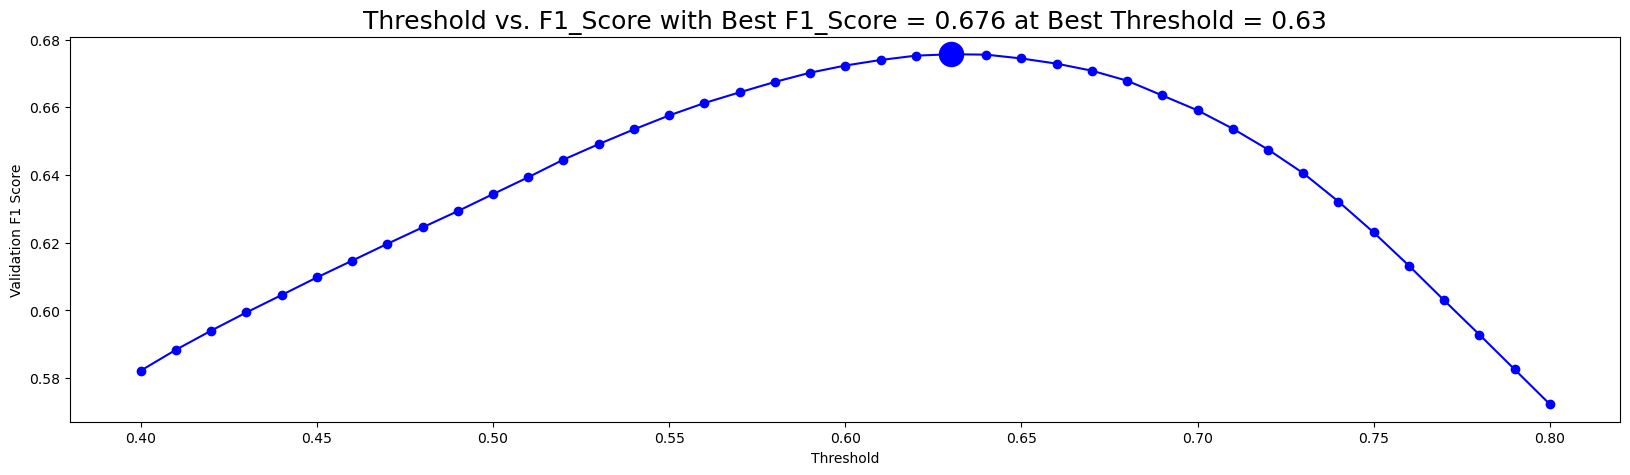

In [367]:
plt.figure(figsize = (20, 5))
plt.plot(thresholds, scores, '-o', color = 'blue')
plt.scatter([best_threshold], [best_score], color = 'blue', s = 300, alpha = 1)
plt.xlabel('Threshold')
plt.ylabel('Validation F1 Score')
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)

In [368]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    metric = f1_score(true[k].values, (oof[k].values > best_threshold).astype('int'), average = 'macro')
    print(f'Q{k}: F1 =', metric)
    
# COMPUTE F1 SCORE OVERALL
metric_overall = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1)) > best_threshold).astype('int'), average = 'macro')
print('==> Overall F1 =', metric_overall)

When using optimal threshold...
Q0: F1 = 0.5853933033830607
Q1: F1 = 0.49464879356568364
Q2: F1 = 0.48598193282124647
Q3: F1 = 0.5857712493791989
Q4: F1 = 0.5474874686178284
Q5: F1 = 0.5933984953467727
Q6: F1 = 0.5743555069378998
Q7: F1 = 0.5388461362663457
Q8: F1 = 0.5915185056534716
Q9: F1 = 0.47198367435381355
Q10: F1 = 0.587394809441438
Q11: F1 = 0.4898902202576143
Q12: F1 = 0.4207342016028435
Q13: F1 = 0.5922842152966947
Q14: F1 = 0.45247638554008623
Q15: F1 = 0.4582508153951264
Q16: F1 = 0.5226861658659998
Q17: F1 = 0.4899126130287569
==> Overall F1 = 0.6757065771825657


### 4.2 Baseline XGBoost: 0.679
- https://www.kaggle.com/code/cdeotte/xgboost-baseline-0-680

In [356]:
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier

#### (i) Feature Engineering
- NUMs 增加 'page','room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration'
- NUMs 增加计算std

In [369]:
CATs = ['event_name', 'fqid','room_fqid', 'text']
NUMs = ['elapsed_time','level', 'page','room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration']
EVENTs = ['navigate_click', 'person_click', 'cutscene_click', 'object_click', 'map_hover', 'notification_click',
            'map_click', 'observation_click', 'checkpoint']

In [372]:
def feature_engineer(train):
    
    dfs = []
    for c in CATs:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMs:
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = tmp.name + '_mean'
        dfs.append(tmp)
    for c in NUMs:
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    for c in EVENTs: 
        train[c] = (train.event_name == c).astype('int8')
    for c in EVENTs + ['elapsed_time']:
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    train = train.drop(EVENTs,axis = 1)
        
    df = pd.concat(dfs,axis = 1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [373]:
df_tr = feature_engineer(train_df)
gc.collect()

15

In [374]:
FEATURES = [c for c in df_tr.columns if c != 'level_group']
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = df_tr.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 30 features
We will train with 23562 users info


#### (ii) Model: XGBoost
- Use data from level_groups = '0-4' to train model for questions 1-3, and level groups '5-12' to train questions 4 thru 13 and level groups '13-22' to train questions 14 thru 18.

In [377]:
# Create a GroupKFold object with 5 splits for cross-validation
gkf = GroupKFold(n_splits = 5)
# Create an empty DataFrame to store out-of-fold predictions
oof = pd.DataFrame(data = np.zeros((len(ALL_USERS), 18)), index = ALL_USERS) 
models = {}  # Create an empty dictionary to store trained models


for i, (train_index, valid_index) in enumerate(gkf.split(X = df_tr, groups = df_tr.index)):
    print('#' * 25)
    print('### Fold', i+1)
    print('#' * 25)
    
    xgb_params = {
        'objective' : 'binary:logistic', # 使用逻辑回归模型进行二分类
        'eval_metric':'logloss', # 评估指标，这里使用'logloss'表示使用对数损失函数进行模型评估
        'learning_rate': 0.05, # 学习率，控制每次迭代中模型参数的更新步长。
        'max_depth': 4, # 树的最大深度，控制树的复杂度，避免过拟合。
        'n_estimators': 1000, 
        'early_stopping_rounds': 50, # 提前停止轮数，如果模型在连续指定轮数中没有明显的性能提升，则提前停止训练。
        'tree_method':'hist', # 基于直方图的算法进行高效计算
        'subsample':0.8, # 样本采样比例，控制每次迭代中训练样本的比例，用于防止过拟合。
        'colsample_bytree': 0.4, # 特征采样比例，控制每次迭代中特征的比例，用于防止过拟合。
        'use_label_encoder' : False} # 是否使用标签编码器，这里设置为False，表示不使用标签编码器。
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        print(t, ', ', end = '')
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<= 3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
        
        # TRAIN DATA
        train_x = df_tr.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = df_tr_label.loc[df_tr_label.question_id == t].set_index('session').loc[train_users]

        # VALID DATA
        valid_x = df_tr.iloc[valid_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = df_tr_label.loc[df_tr_label.question_id == t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
               eval_set = [ (valid_x[FEATURES].astype('float32'), valid_y['correct']) ],
               verbose = 0) # 不显示训练过程详细信息
        print(f'{t}({clf.best_ntree_limit}), ', end='') # 打印当前迭代轮数（t）以及最佳树数量（clf.best_ntree_limit）
        
        # SAVE MODEL, PREDICT VALID OOF
        # 将训练好的模型对象 clf 存储在 models 字典中
        models[f'{grp}_{t}'] = clf
        # 进行验证集的预测并将预测结果存储在 oof DataFrame 中
        # 使用模型的 predict_proba 方法来获取预测的概率值，然后通过索引操作 [:,1] 取出预测结果中属于正类的概率值。
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()

#########################
### Fold 1
#########################
1 , 1(137), 2 , 2(150), 3 , 3(140), 4 , 4(246), 5 , 5(133), 6 , 6(139), 7 , 7(89), 8 , 8(76), 9 , 9(136), 10 , 10(220), 11 , 11(106), 12 , 12(122), 13 , 13(159), 14 , 14(149), 15 , 15(225), 16 , 16(66), 17 , 17(84), 18 , 18(120), 
#########################
### Fold 2
#########################
1 , 1(150), 2 , 2(158), 3 , 3(110), 4 , 4(180), 5 , 5(142), 6 , 6(105), 7 , 7(103), 8 , 8(54), 9 , 9(104), 10 , 10(120), 11 , 11(132), 12 , 12(143), 13 , 13(160), 14 , 14(227), 15 , 15(225), 16 , 16(141), 17 , 17(68), 18 , 18(159), 
#########################
### Fold 3
#########################
1 , 1(250), 2 , 2(124), 3 , 3(128), 4 , 4(250), 5 , 5(133), 6 , 6(110), 7 , 7(102), 8 , 8(52), 9 , 9(124), 10 , 10(135), 11 , 11(91), 12 , 12(75), 13 , 13(100), 14 , 14(203), 15 , 15(357), 16 , 16(82), 17 , 17(143), 18 , 18(167), 
#########################
### Fold 4
#########################
1 , 1(140), 2 , 2(137), 3 , 3(103), 4 , 4(257), 5 , 5

#### (iii) True Values

In [378]:
true = oof.copy()
for k in range(18):
    temp = df_tr_label.loc[df_tr_label.question_id == k+1].set_index('session').loc[ALL_USERS]
    true[k] = temp.correct.values

#### (iv) Find the Threshold

In [379]:
scores = []; thresholds = [] # 存储每个阈值对应的F1得分和阈值值。
best_score = 0; best_threshold = 0
for threshold in np.arange(0.4, 0.81, 0.01):
    print(f'{threshold:.02f}, ', end = '')
    preds = (oof.values.reshape((-1)) > threshold).astype('int')
    metric = f1_score(true.values.reshape((-1)), preds, average = 'macro') # 宏平均值
    scores.append(metric)
    thresholds.append(threshold)
    if metric > best_score:
        best_score = metric
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

Text(0.5, 1.0, 'Threshold vs. F1_Score with Best F1_Score = 0.679 at Best Threshold = 0.63')

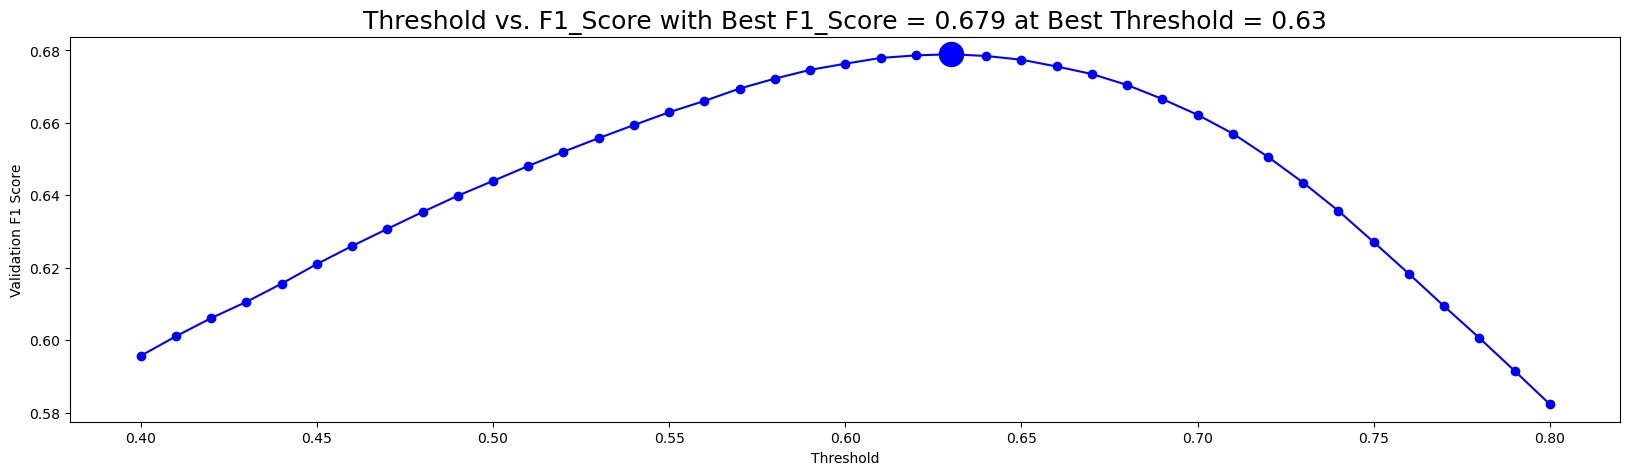

In [380]:
plt.figure(figsize = (20, 5))
plt.plot(thresholds, scores, '-o', color = 'blue')
plt.scatter([best_threshold], [best_score], color = 'blue', s = 300, alpha = 1)
plt.xlabel('Threshold')
plt.ylabel('Validation F1 Score')
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)

In [381]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    metric = f1_score(true[k].values, (oof[k].values > best_threshold).astype('int'), average = 'macro')
    print(f'Q{k}: F1 =', metric)
    
# COMPUTE F1 SCORE OVERALL
metric_overall = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1)) > best_threshold).astype('int'), average = 'macro')
print('==> Overall F1 =', metric_overall)

When using optimal threshold...
Q0: F1 = 0.6007334525331299
Q1: F1 = 0.49464879356568364
Q2: F1 = 0.48979468599033815
Q3: F1 = 0.6204799821394094
Q4: F1 = 0.5786983254176092
Q5: F1 = 0.609556414274521
Q6: F1 = 0.5851820312223064
Q7: F1 = 0.53218678317002
Q8: F1 = 0.6001086221368785
Q9: F1 = 0.5204238250526128
Q10: F1 = 0.5901744888963553
Q11: F1 = 0.4970965188960832
Q12: F1 = 0.4386493882112896
Q13: F1 = 0.6088487387947606
Q14: F1 = 0.5180346273619569
Q15: F1 = 0.47030196891875703
Q16: F1 = 0.5401365730733185
Q17: F1 = 0.48897234791538835
==> Overall F1 = 0.6789504857565638


### 4.3 Baseline CPU CatBoost(Using Polars)
- https://www.kaggle.com/code/carnozhao/cpu-catboost-baseline-using-polars-inference

In [393]:
import polars as pl
from catboost import CatBoostClassifier, Pool

#### (i) Feature Engineering

In [394]:
CATs = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMs = ['elapsed_time','level', 'page','room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration', 'time_past']
EVENTs = ['navigate_click', 'person_click', 'cutscene_click', 'object_click', 'map_hover', 'notification_click',
            'map_click', 'observation_click', 'checkpoint']